# Tunnel Squeezing Classification Using Random Forest

**Objective**: Predict tunnel squeezing severity using Random Forest with class balancing and feature importance analysis.

---
## 1. Problem Statement

**Tunnel squeezing** is time-dependent rock deformation that causes TBM entrapment and construction delays.

| Class | Severity | Strain (ε) | Engineering Response |
|-------|----------|------------|---------------------|
| **1** | Non-squeezing | < 1% | Standard support |
| **2** | Minor | 1% – 2.5% | Enhanced monitoring |
| **3** | Severe | ≥ 2.5% | Heavy support required |

### Why Random Forest?
- Handles non-linear relationships well
- Provides **feature importance** rankings
- Robust to overfitting with proper tuning
- No scaling required (tree-based)

---
## 2. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, 
    cross_val_score, learning_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

CLASS_NAMES = ['Non-squeezing', 'Minor', 'Severe']
CLASS_COLORS = ['#27ae60', '#f39c12', '#c0392b']

import warnings
warnings.filterwarnings('ignore')

print("Setup complete.")

Setup complete.


---
## 3. Data Loading

In [2]:
df = pd.read_csv('data/raw/tunnel.csv')

if 'No' in df.columns:
    df = df.drop(columns=['No'])

df = df[df['K(MPa)'] > 0].copy()

print(f"Dataset: {df.shape[0]} samples")
print(f"\nClass distribution:")
print(df['Class'].value_counts().sort_index())

Dataset: 114 samples

Class distribution:
Class
1    30
2    24
3    60
Name: count, dtype: int64


---
## 4. EDA

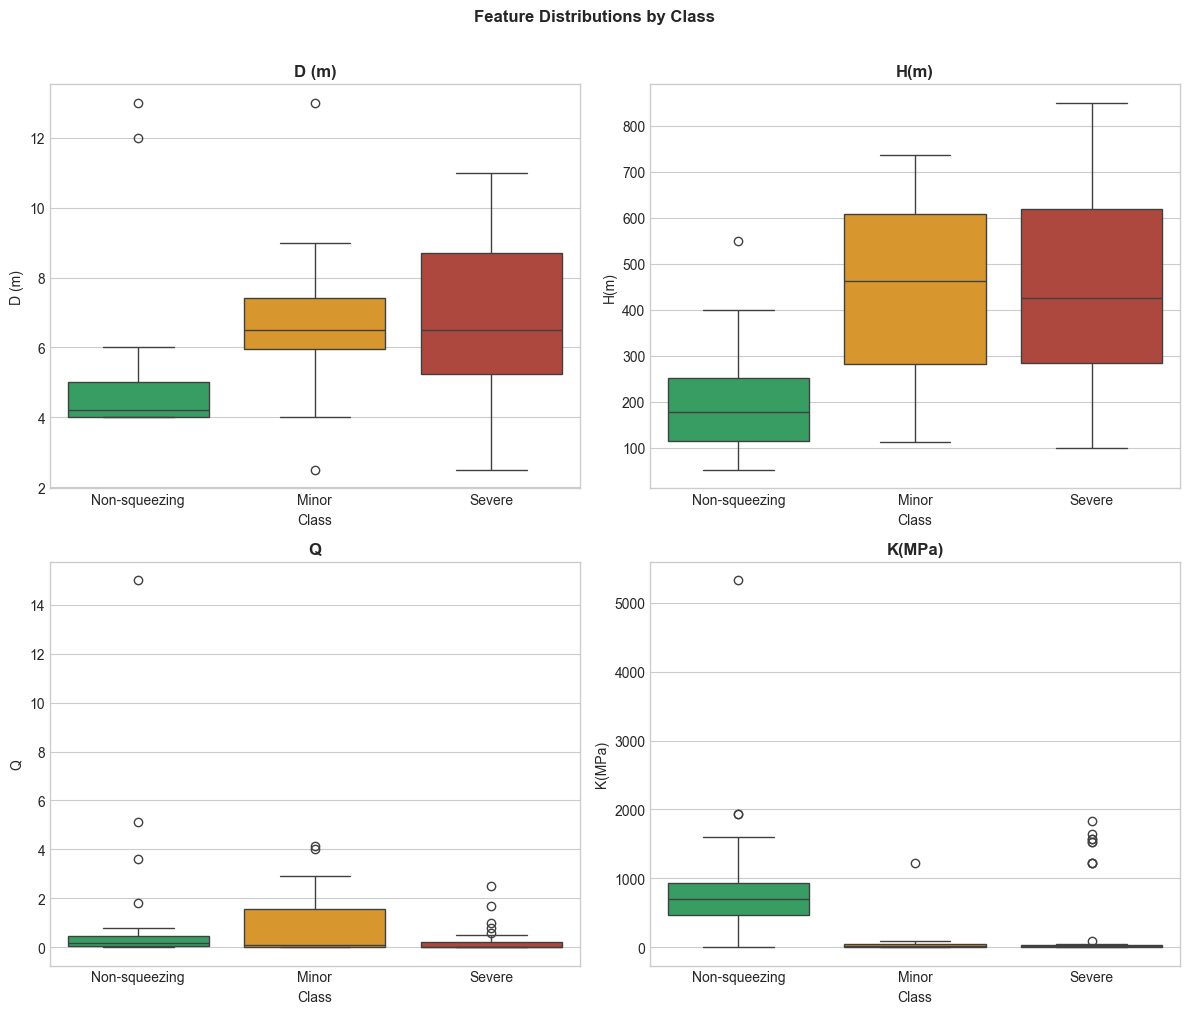

In [3]:
features = ['D (m)', 'H(m)', 'Q', 'K(MPa)']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, feat in enumerate(features):
    ax = axes.flat[i]
    sns.boxplot(x='Class', y=feat, data=df, ax=ax, palette=CLASS_COLORS)
    ax.set_xticklabels(CLASS_NAMES)
    ax.set_title(feat, fontweight='bold')

plt.suptitle('Feature Distributions by Class', fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

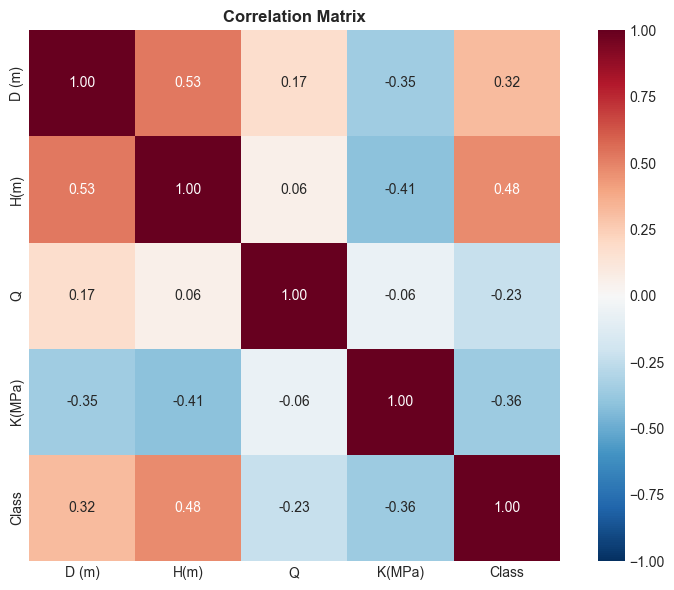

In [4]:
# Correlation
corr = df[features + ['Class']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='RdBu_r', fmt='.2f', vmin=-1, vmax=1, square=True)
plt.title('Correlation Matrix', fontweight='bold')
plt.tight_layout()
plt.show()

---
## 5. Data Preparation

In [5]:
X = df[features].values
y = df['Class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training: {len(y_train)} | Test: {len(y_test)}")

Training: 91 | Test: 23


---
## 6. Random Forest with SMOTE

In [6]:
# Pipeline with SMOTE
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE))
])

# Hyperparameter grid
param_grid = {
    'rf__n_estimators': [50, 100, 200, 300],
    'rf__max_depth': [None, 5, 10, 15, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("Running GridSearchCV...")

Running GridSearchCV...


In [7]:
grid_search = GridSearchCV(
    pipeline, param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n" + "="*50)
print("BEST HYPERPARAMETERS")
print("="*50)
for param, value in grid_search.best_params_.items():
    print(f"  {param.replace('rf__', '')}: {value}")
print(f"\nBest CV F1-macro: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits



BEST HYPERPARAMETERS
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 50

Best CV F1-macro: 0.7922


---
## 7. Model Evaluation

In [8]:
model = grid_search.best_estimator_
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print("="*50)
print("TEST SET PERFORMANCE")
print("="*50)
print(f"Accuracy:           {acc:.1%}")
print(f"Balanced Accuracy:  {bal_acc:.1%}")
print(f"F1-score (macro):   {f1:.3f}")
print("="*50)

TEST SET PERFORMANCE
Accuracy:           87.0%
Balanced Accuracy:  87.8%
F1-score (macro):   0.866


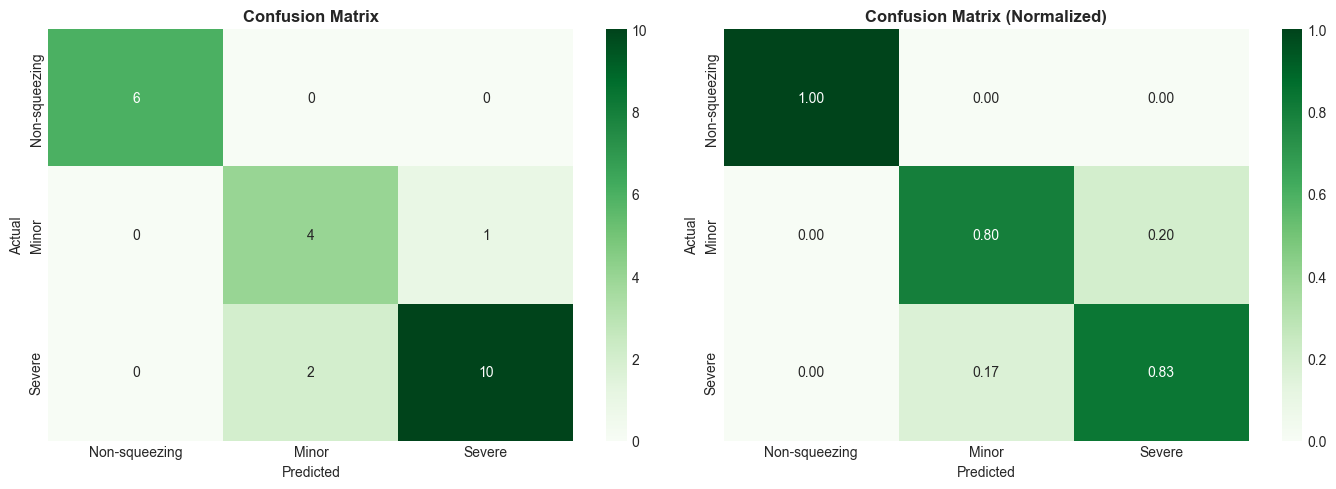

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix', fontweight='bold')

# Normalized
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (Normalized)', fontweight='bold')

plt.tight_layout()
plt.show()

In [10]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

Classification Report:
               precision    recall  f1-score   support

Non-squeezing       1.00      1.00      1.00         6
        Minor       0.67      0.80      0.73         5
       Severe       0.91      0.83      0.87        12

     accuracy                           0.87        23
    macro avg       0.86      0.88      0.87        23
 weighted avg       0.88      0.87      0.87        23



### 7.1 ROC Curves

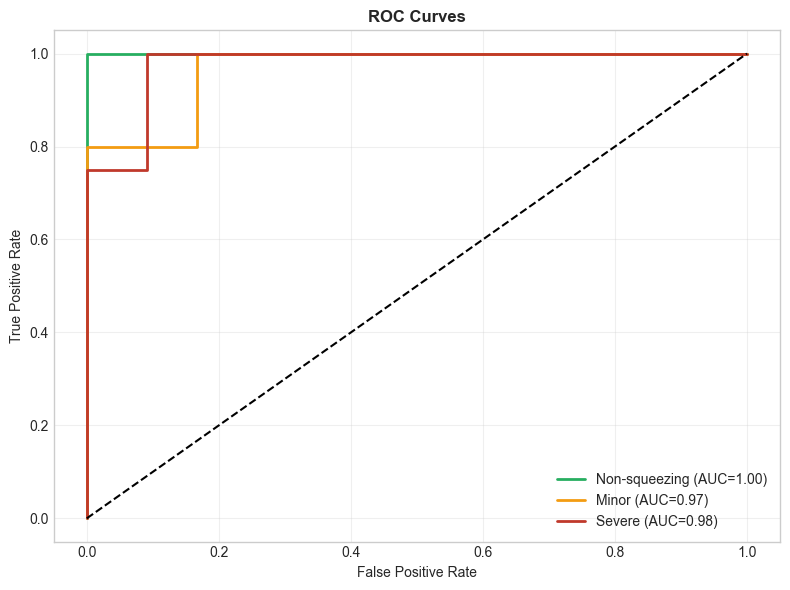

In [11]:
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])

fig, ax = plt.subplots(figsize=(8, 6))

for i, (name, color) in enumerate(zip(CLASS_NAMES, CLASS_COLORS)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{name} (AUC={roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves', fontweight='bold')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## 8. Feature Importance (Random Forest Advantage)

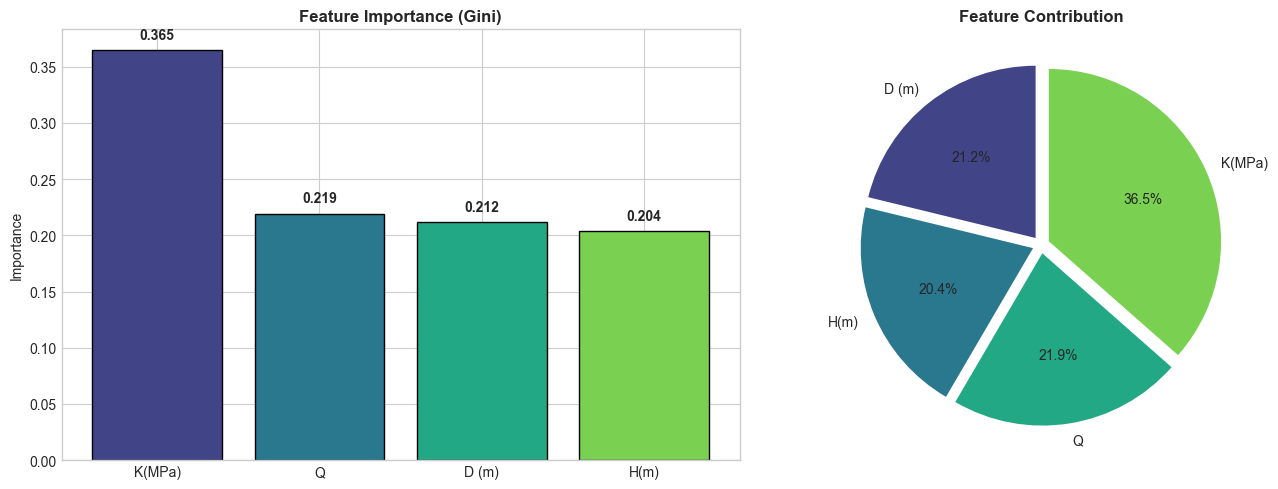

Feature Ranking:
  1. K(MPa): 0.3650
  2. Q: 0.2193
  3. D (m): 0.2119
  4. H(m): 0.2038


In [12]:
# Extract RF from pipeline
rf_model = model.named_steps['rf']
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(features)))
bars = axes[0].bar(range(len(features)), importances[indices], color=colors, edgecolor='black')
axes[0].set_xticks(range(len(features)))
axes[0].set_xticklabels([features[i] for i in indices])
axes[0].set_ylabel('Importance')
axes[0].set_title('Feature Importance (Gini)', fontweight='bold')
for bar, imp in zip(bars, importances[indices]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{imp:.3f}', ha='center', fontweight='bold')

# Pie chart
axes[1].pie(importances, labels=features, autopct='%1.1f%%', colors=colors,
            explode=[0.05]*len(features), startangle=90)
axes[1].set_title('Feature Contribution', fontweight='bold')

plt.tight_layout()
plt.show()

print("Feature Ranking:")
for i, idx in enumerate(indices):
    print(f"  {i+1}. {features[idx]}: {importances[idx]:.4f}")

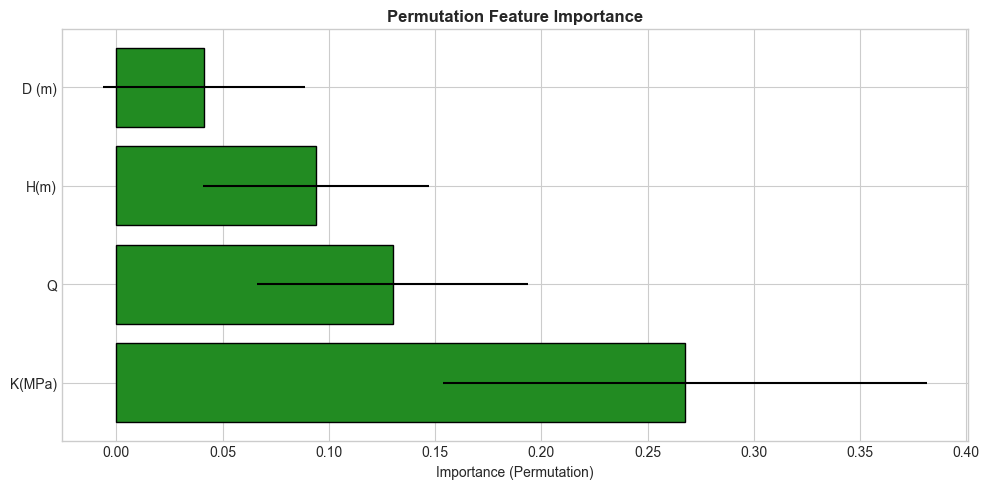

In [13]:
# Permutation importance (more reliable)
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(
    model, X_test, y_test, 
    n_repeats=30, random_state=RANDOM_STATE, scoring='f1_macro'
)

sorted_idx = perm_importance.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 5))
plt.barh(range(len(features)), perm_importance.importances_mean[sorted_idx],
         xerr=perm_importance.importances_std[sorted_idx],
         color='forestgreen', edgecolor='black')
plt.yticks(range(len(features)), [features[i] for i in sorted_idx])
plt.xlabel('Importance (Permutation)')
plt.title('Permutation Feature Importance', fontweight='bold')
plt.tight_layout()
plt.show()

---
## 9. Learning Curves

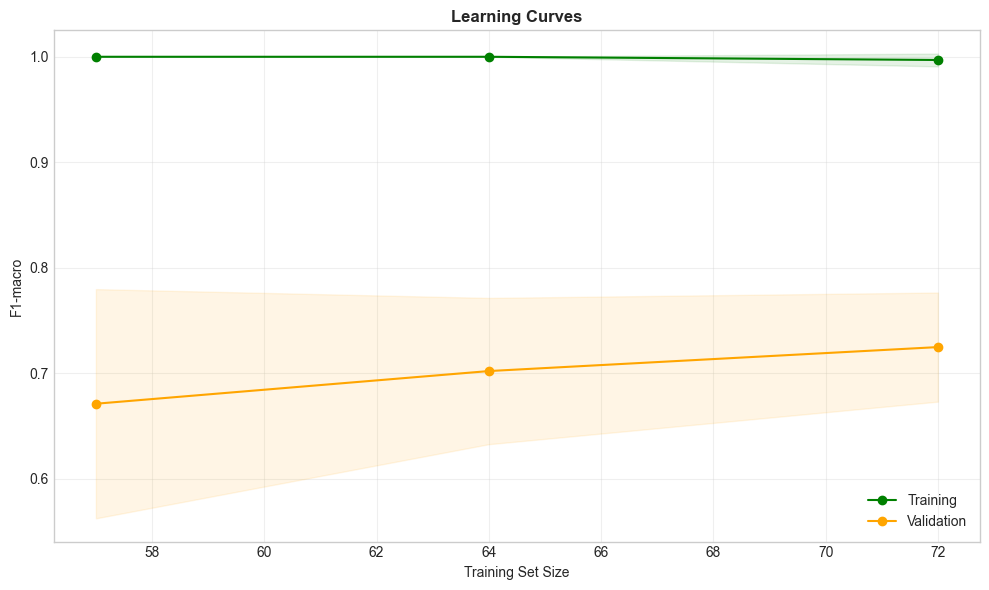

In [14]:
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1_macro'
)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores.mean(1) - train_scores.std(1), 
                 train_scores.mean(1) + train_scores.std(1), alpha=0.1, color='green')
plt.fill_between(train_sizes, val_scores.mean(1) - val_scores.std(1), 
                 val_scores.mean(1) + val_scores.std(1), alpha=0.1, color='orange')
plt.plot(train_sizes, train_scores.mean(1), 'o-', color='green', label='Training')
plt.plot(train_sizes, val_scores.mean(1), 'o-', color='orange', label='Validation')
plt.xlabel('Training Set Size')
plt.ylabel('F1-macro')
plt.title('Learning Curves', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## 10. Engineering Interpretation

### Feature Importance Insights

Based on the Random Forest analysis:

| Feature | Importance | Physical Meaning |
|---------|------------|------------------|
| **H (m)** | Highest | Overburden depth = in-situ stress |
| **K (MPa)** | High | Rock stiffness determines deformation |
| **Q** | Medium | Rock quality influences squeezing potential |
| **D (m)** | Lower | Diameter affects stress redistribution |

### Why Random Forest Works Well
- Captures non-linear feature interactions
- Robust to outliers in Q and K values
- Provides interpretable feature rankings

---
## 11. Limitations & Future Work

**Limitations**: Small dataset, class imbalance, no site-specific geology

**Future Work**: Expand data, compare with SVM/XGBoost, add SHAP analysis

---
## 12. Model Export

In [15]:
import joblib

joblib.dump(model, 'models/rf_tunnel_squeezing.pkl')
print("Model saved: models/rf_tunnel_squeezing.pkl")

# Example
print("\n--- Prediction Example ---")
sample = [[6.0, 400, 0.3, 20]]
pred = model.predict(sample)[0]
proba = model.predict_proba(sample)[0]
print(f"Input: D=6m, H=400m, Q=0.3, K=20 MPa")
print(f"Predicted: Class {pred} ({CLASS_NAMES[pred-1]})")
print(f"Probabilities: {dict(zip(CLASS_NAMES, proba.round(3)))}")

Model saved: models/rf_tunnel_squeezing.pkl

--- Prediction Example ---
Input: D=6m, H=400m, Q=0.3, K=20 MPa
Predicted: Class 2 (Minor)
Probabilities: {'Non-squeezing': np.float64(0.1), 'Minor': np.float64(0.5), 'Severe': np.float64(0.4)}


---
**Author**: Sudip Adhikari | **Date**: January 2026